### This script gets sample statistics, fits truncated lognormal distirbution and then runs Monte-Carlo trials to assess the target function outcomes. 

In [1]:
#БАЗОВЫЕ БИБЛИОТЕКИ
import pandas as pd
import numpy as np
import numpy.random as rn

#CИСТЕМНЫЕ БИБЛИОТЕКИ
import sys
import glob

#ГРАФИЧЕСКИЕ БИБЛИОТЕКИ
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as st

In [4]:
def eur(qi, b, Di, TDR):
    """ Функция для расчета накопленной добычи по скважине по аналитической модели"""
    # qi - суточный дебит, т/сут, Di и TDR в годовом выражении
    Darps = Di/365
    Dexp = -np.log(1-TDR/100)/365
    tlim = (1/Dexp - 1/Darps)/b
    Qarps = 1/((1-b)*Darps)*(1-(1+b*Darps*tlim)**(1-1/b))
    qi_exp = 1/((1+b*Darps*tlim)**(1/b))
    Qexp = qi_exp/Dexp*(1-np.exp(-Dexp*(5959-tlim)))
    S = Qarps + Qexp
    Qtotal = round(qi*S,0)
    
    return Qtotal

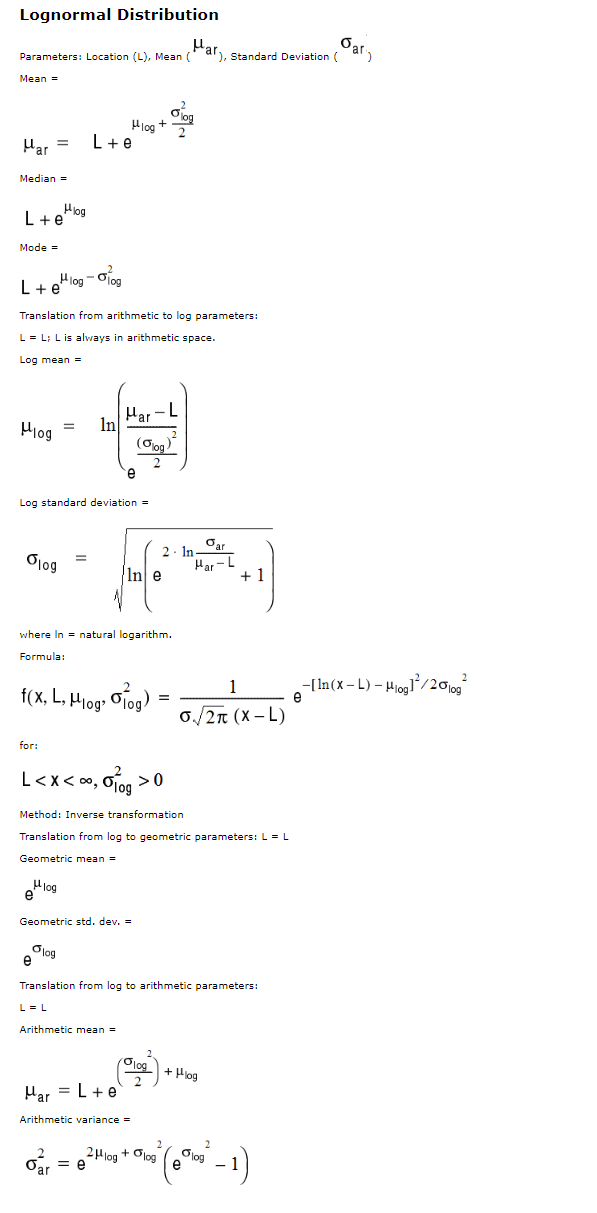

In [70]:
def dist_log_trunc(p_low, q_low, p_high, q_high, p_mean, N, graph):
    
    """Функция для моделирования усеченного логормального распределения"""
    
    # На входе параметры p_low и p_high - значения дебитов на соответствующих персентилях. 
    # q_low и q_high - значения квантилей
    # Cреднее по выборке и количество итераций
    # Параметр graph определяет необходимость отображения графиков: 0 - не нужны, 1 - нужны. 
    
    p = np.linspace(0.01, p_high+100, 1000)
    p_log = np.apply_along_axis(np.log, 0, p)
    
    std = (p_high - p_low)/(st.norm().ppf(q = 1-0.01*q_high)-st.norm().ppf(q = 1-0.01*q_low))
    
    sigma = (np.log(np.exp(2*np.log(std/p_mean))+1))**0.5
    mu = np.log(p_mean/np.exp(sigma**2/2))
    
    norm_lower = np.log(p_low)
    norm_upper = np.log(p_high)
    
    rv = st.truncnorm((norm_lower-mu)/sigma, (norm_upper-mu)/sigma, loc = mu, scale = sigma)
    pdf_out = np.exp(rv.pdf(p_log))
    sample = np.exp(rv.rvs(size = N))
    
    if graph==1:
    
        plt.figure(figsize = (12.0,12.0))
        sns.lineplot(x = p, y = pdf_out)

        plt.figure(figsize = (12.0,12.0))
        sns.histplot(data = sample, stat = 'probability')
    
    return sample
    


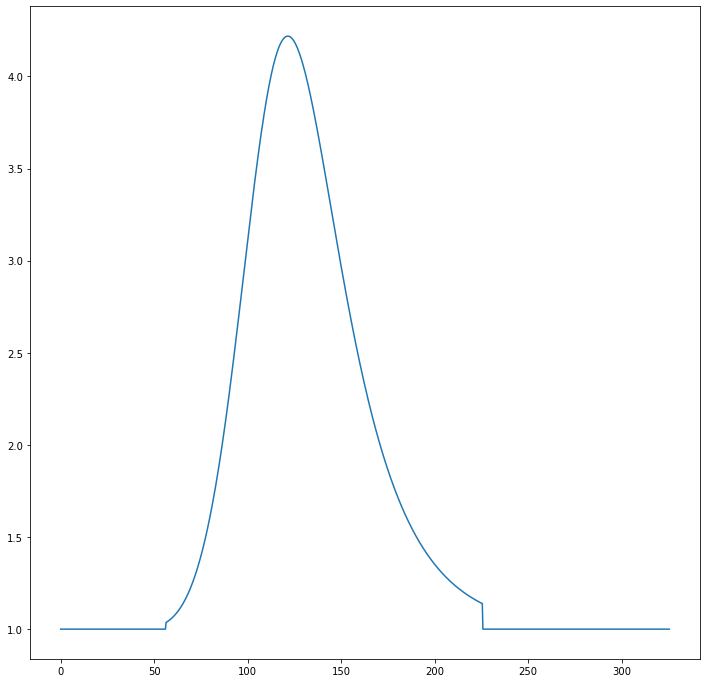

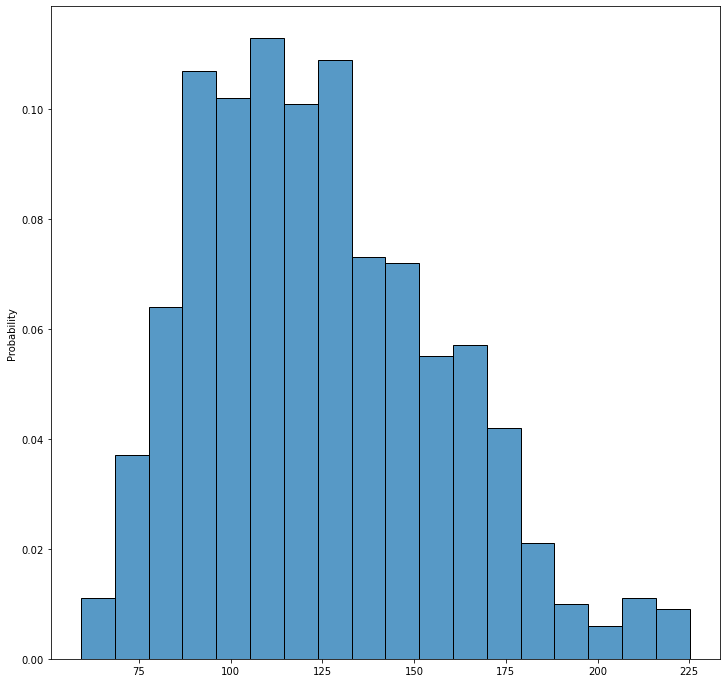

In [56]:
rv_qi = dist_log_trunc(56.3, 99, 225.5, 1, 126.4, 1000, 1)

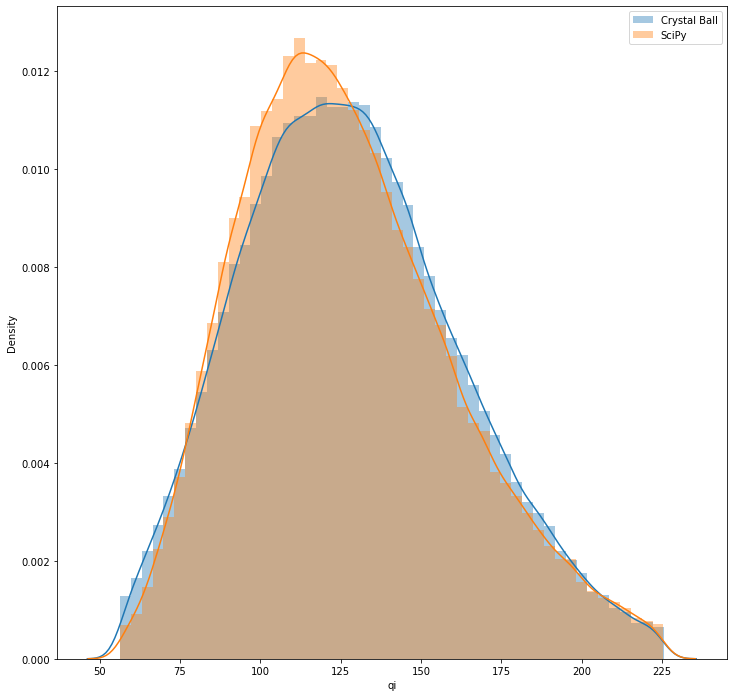

In [100]:
# Сравнение модельных распределений (усеченное логнормальное распределение) из Crystal Ball и из SciPy

qi_CB = pd.read_csv('Qi_CB.txt', sep = '\t', names = ['qi'])
qi_CB.head()

plt.figure(figsize=(12.0,12.0))
sns.distplot(a = qi_CB['qi'], norm_hist = True, label = 'Crystal Ball', )
sns.distplot(a = df['qi'], norm_hist = True, label = 'SciPy')
plt.legend()

In [48]:
def dist_uniform(p_min, p_max, N, graph):

    """Функция для моделирования равномерного распределения"""
    
    p = np.linspace(p_min, p_max, 1000)
    rv = st.uniform(loc = p_min, scale = p_max - p_min)
    sample = rv.rvs(size = N)
    
    if graph==1:
        
        plt.figure(figsize = (12.0,12.0))
        sns.lineplot(x = p, y = rv.pdf(p))

        plt.figure(figsize = (12.0,12.0))
        sns.histplot(data = sample, stat = 'probability')
    
    return sample

In [95]:
def calc_trials(rv_qi, rv_b, rv_D, rv_TDR):
    """Функция для расчета распределения накопленной добычи на скважину"""
    
    EUR = []  

    for a,b,c,d in zip(rv_qi, rv_b, rv_D, rv_TDR): 
        EUR.append(eur(a,b,c,d))
    EUR = np.array(EUR)

    df = pd.DataFrame({'qi':rv_qi, 'b':rv_b, 'D':rv_D, 'TDR':rv_TDR, 'EUR':EUR})
    
    P90 = round(df['EUR'].quantile(q=0.1),0)
    P50 = round(df['EUR'].quantile(q=0.5),0)
    P10 = round(df['EUR'].quantile(q=0.9),0)
    
    print('********************************************\nНакопленная добыча на скважину {a} тыс.т\n'.format(a = P90))
    print('********************************************\nНакопленная добыча на скважину {a} тыс.т\n'.format(a = P50))
    print('********************************************\nНакопленная добыча на скважину {a} тыс.т\n'.format(a = P10))

    
    return df

In [99]:
#Создаем случайную реализацию массивов входных параметров. размер массива соответствует количество итераций в расчете Монте-Карло

N = 100000

rv_qi = dist_log_trunc(56.3, 99, 225.5, 1, 128.6, N, 0)
rv_b = dist_uniform(1.13, 3, N,0)
rv_D = dist_uniform(2.54, 17.43, N,0)
rv_TDR = dist_uniform(9.12, 29.78, N,0)

df = calc_trials(rv_qi, rv_b, rv_D, rv_TDR)

********************************************
Накопленная добыча на скважину 28497.0 тыс.т

********************************************
Накопленная добыча на скважину 57618.0 тыс.т

********************************************
Накопленная добыча на скважину 105370.0 тыс.т



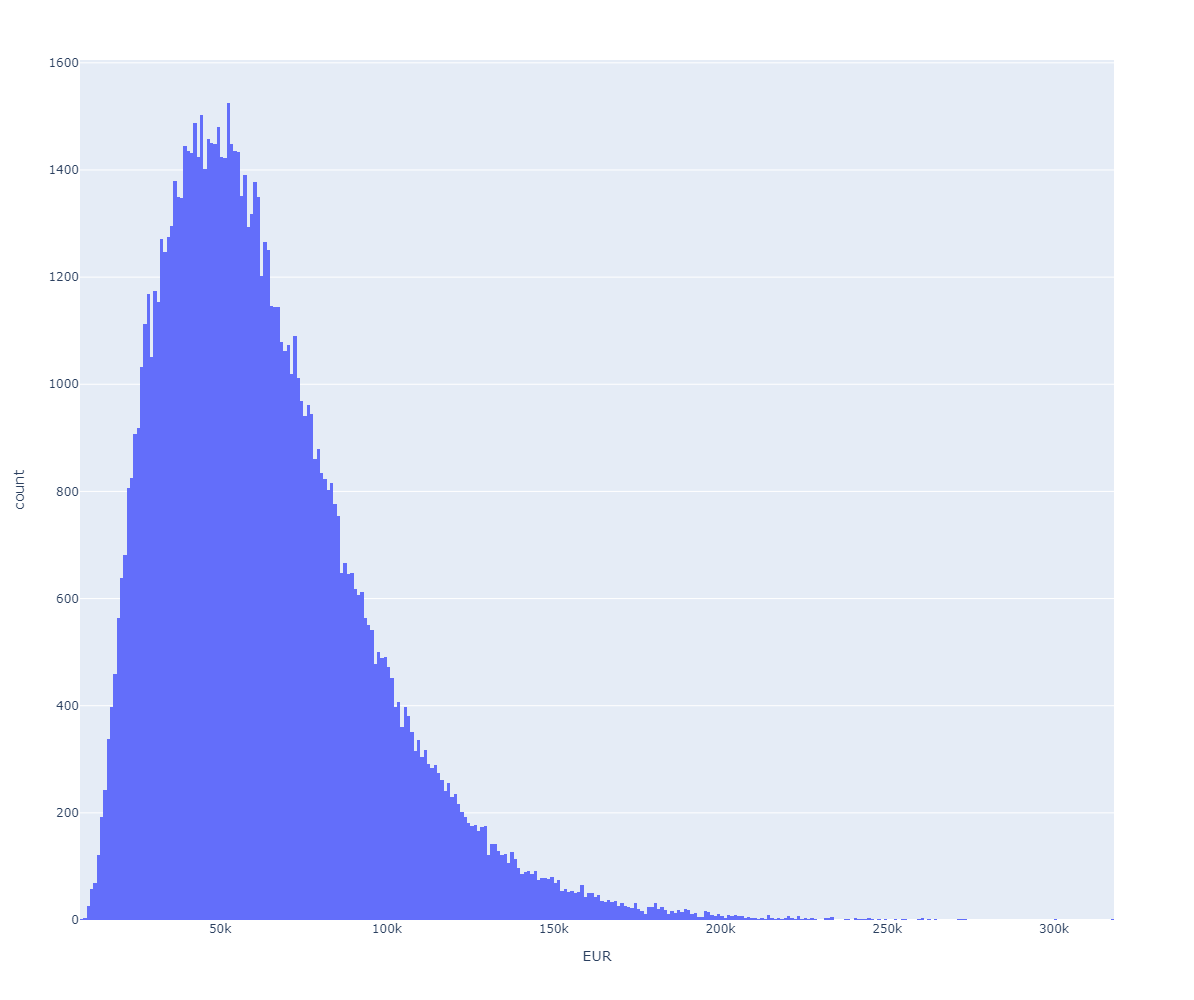

In [107]:
fig = px.histogram(df, x='EUR', hover_data=df.columns, width = 1500.0, height = 1000.0)
fig.show(width = 15.0, height = 5.0)

********************************************
Накопленная добыча на скважину 28497.0 тыс.т

********************************************
Накопленная добыча на скважину 57618.0 тыс.т

********************************************
Накопленная добыча на скважину 105370.0 тыс.т



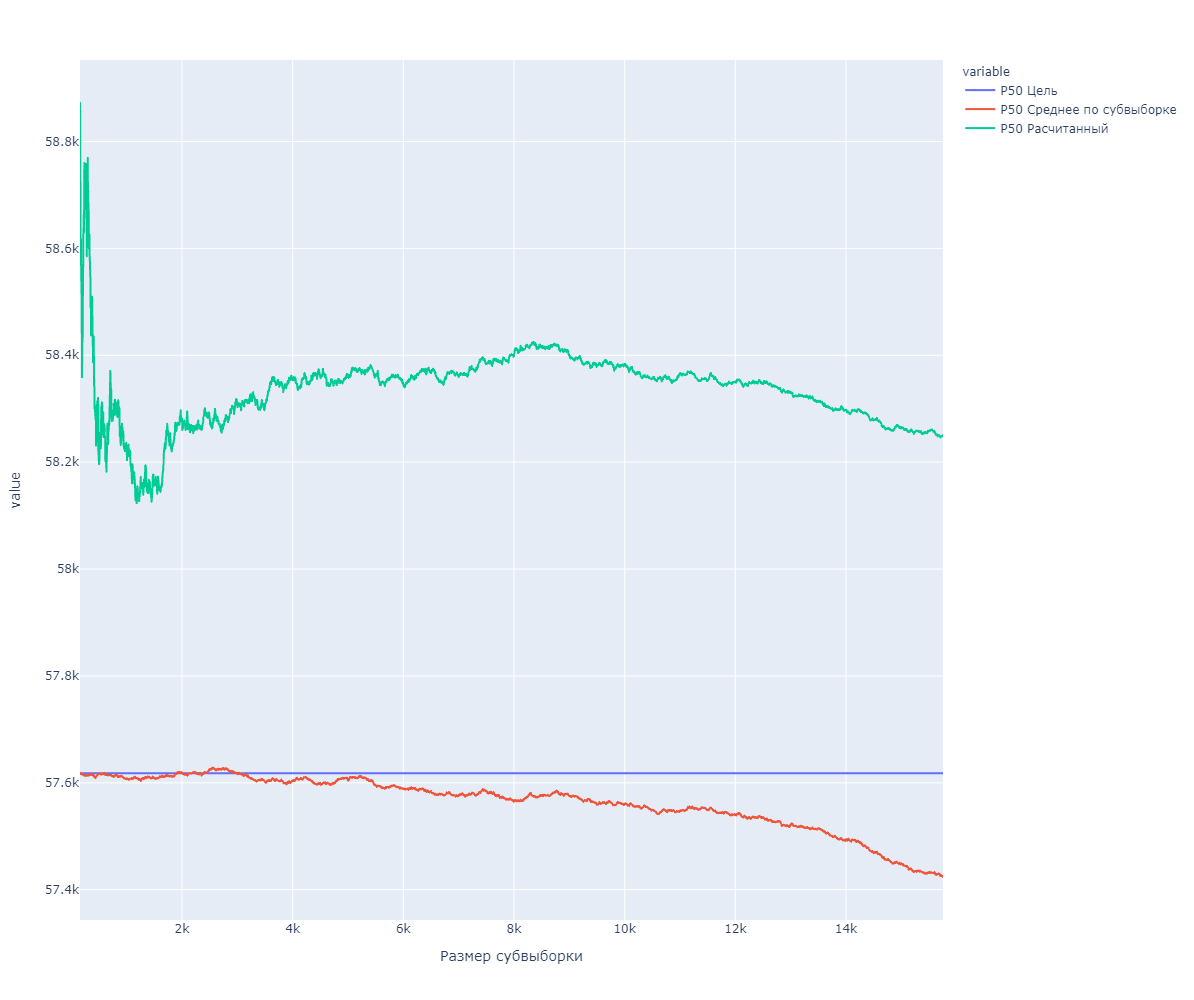

In [116]:
# Расчет влияния размера субвыборки вокруг целевого сценария на итоговую оценку

tolerance = np.linspace(0.1,10,5000) #в процентах

size_v = []
Р50_v = []
P50_subsample_v = [] 
EUR_calc_v = []

df_a = calc_trials(rv_qi, rv_b, rv_D, rv_TDR)
Р50 = df_a['EUR'].quantile(q=0.5)

for i in tolerance:

    Р50_v.append(Р50)
    sub_sample = df_a[(df_a['EUR']> Р50-0.01*i*Р50) & (df_a['EUR']< Р50+0.01*i*Р50)]
    size_v.append(sub_sample.shape[0])
    
    P50_subsample = sub_sample['EUR'].mean()
    P50_subsample_v.append(P50_subsample)

    qi_calc = sub_sample['qi'].mean()
    b_calc = sub_sample['b'].mean()
    D_calc = sub_sample['D'].mean()
    TDR_calc = sub_sample['TDR'].mean()

    EUR_calc = eur(qi_calc, b_calc, D_calc, TDR_calc)
    EUR_calc_v.append(EUR_calc)
    
df_ss = pd.DataFrame({'Tolerance_%': tolerance, 'Размер субвыборки':size_v, 'P50 Цель': Р50_v, 'P50 Среднее по субвыборке':P50_subsample_v, 'P50 Расчитанный':EUR_calc_v } )

fig = px.line(df_ss, x='Размер субвыборки', y = df_ss.columns[1:5], width = 1500.0, height = 1000.0)
fig.show()

In [119]:
def convergence(tolerance, N):

    rv_qi = dist_log_trunc(56.3, 99, 225.5, 1, 128.6, N, 0)
    rv_b = dist_uniform(1.13, 3, N,0)
    rv_D = dist_uniform(2.54, 17.43, N,0)
    rv_TDR = dist_uniform(9.12, 29.78, N,0)

    df = calc_trials(rv_qi, rv_b, rv_D, rv_TDR)

    Р50 = df_a['EUR'].quantile(q=0.5)

    sub_sample = df_a[(df_a['EUR']> Р50-0.01*i*Р50) & (df_a['EUR']< Р50+0.01*i*Р50)]
    size = sub_sample.shape[0]

    P50_subsample = sub_sample['EUR'].mean()

    qi_calc = sub_sample['qi'].mean()
    b_calc = sub_sample['b'].mean()
    D_calc = sub_sample['D'].mean()
    TDR_calc = sub_sample['TDR'].mean()

    EUR_calc = eur(qi_calc, b_calc, D_calc, TDR_calc)

    return size, Р50, P50_subsample, EUR_calc

In [122]:
a = convergence(10, 50000)

a[0]

********************************************
Накопленная добыча на скважину 28525.0 тыс.т

********************************************
Накопленная добыча на скважину 57506.0 тыс.т

********************************************
Накопленная добыча на скважину 105632.0 тыс.т



15753

In [127]:
tolerance = [0.01, 0.1, 0.5, 1, 2, 2.5, 5, 10, 20, 25]
trials = [10000, 50000, 100000, 250000, 500000, 1000000, 2500000]

tol = []
n = []
size = []
P50 = []
P50_subsample = []
EUR_calc = []


for i in tolerance:
    for j in trials:
        tol.append(i)
        n.append(j)
        a = convergence(i,j)
        
        size.append(a[0])
        P50.append(a[1])
        P50_subsample.append(a[2])
        EUR_calc.append(a[3])

df_test = pd.DataFrame(
                        {'Tolerance':tol, 
                         'Trials':n,
                         'Size':size,
                         'P50':P50, 
                         'P50_subsample': P50_subsample,
                         'EUR_calc': EUR_calc
                       }
                      )
        

********************************************
Накопленная добыча на скважину 28804.0 тыс.т

********************************************
Накопленная добыча на скважину 58250.0 тыс.т

********************************************
Накопленная добыча на скважину 105849.0 тыс.т

********************************************
Накопленная добыча на скважину 28692.0 тыс.т

********************************************
Накопленная добыча на скважину 57394.0 тыс.т

********************************************
Накопленная добыча на скважину 105276.0 тыс.т

********************************************
Накопленная добыча на скважину 28537.0 тыс.т

********************************************
Накопленная добыча на скважину 57595.0 тыс.т

********************************************
Накопленная добыча на скважину 105287.0 тыс.т

********************************************
Накопленная добыча на скважину 28719.0 тыс.т

********************************************
Накопленная добыча на скважину 57674.0 тыс

In [130]:
df_test.head(25)

,Tolerance,Trials,Size,P50,P50_subsample,EUR_calc
0,0.01,10000,14,57618.0,57617.000000,59929.0
1,0.01,50000,14,57618.0,57617.000000,59929.0
2,0.01,100000,14,57618.0,57617.000000,59929.0
3,0.01,250000,14,57618.0,57617.000000,59929.0
4,0.01,500000,14,57618.0,57617.000000,59929.0
5,0.01,1000000,14,57618.0,57617.000000,59929.0
6,0.01,2500000,14,57618.0,57617.000000,59929.0
7,0.10,10000,158,57618.0,57616.867089,58872.0
8,0.10,50000,158,57618.0,57616.867089,58872.0
9,0.10,100000,158,57618.0,57616.867089,58872.0


<AxesSubplot:xlabel='Size', ylabel='P50_subsample'>

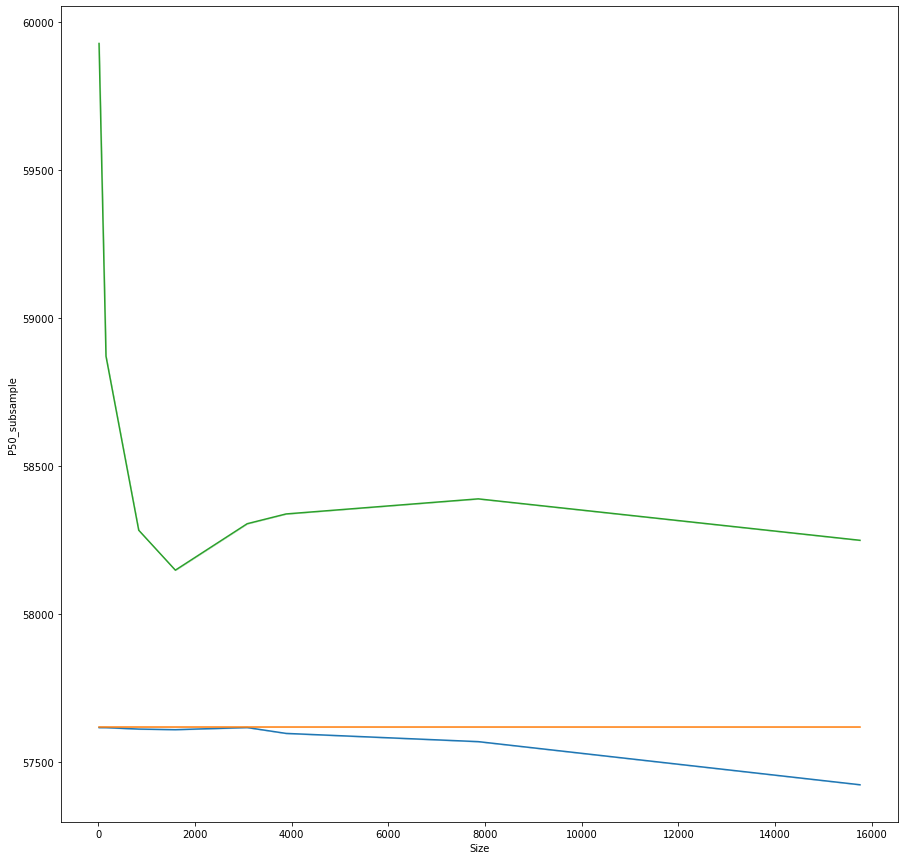

In [135]:
plt.figure(figsize = (15.0,15.0))

df_test_f = df_test[(df_test['Tolerance'] == 0.01)]
sns.lineplot(x = df_test['Size'], y = df_test['P50_subsample'])
sns.lineplot(x = df_test['Size'], y = df_test['P50'])
sns.lineplot(x = df_test['Size'], y = df_test['EUR_calc'])